In [750]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

n_splits = 10
seed = 42
np.random.seed(seed)

k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [751]:
with open("final_model_clustered/kmeans_model.pkl", "rb") as file:
    kmeans_model = pickle.load(file)

#### 1 Read and describe data

In [752]:
matches_df = pd.read_csv("../../../data_for_training/arsenal.csv")
matches_df.columns

Index(['result', 'venue', 'season', 'win_percent_before_team2',
       'win_percent_diff', 'draw_percent_before_team2',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team1', 'average_score_before_match_team2',
       'average_score_before_match_diff'],
      dtype='object')

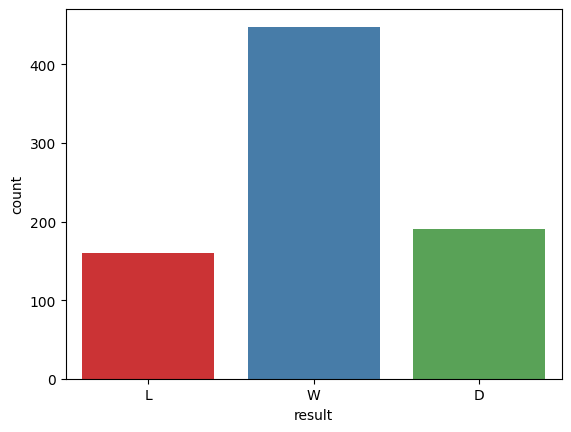

In [753]:
matches_df = matches_df.drop(
    columns=[
        "average_score_before_match_team1",
        "average_score_before_match_diff",
        "draw_percent_before_team2",
    ]
)

sns.countplot(x="result", data=matches_df, palette="Set1");

### Phân chia dữ liệu thành X, y

In [754]:
X = matches_df.drop("result", axis=1)
X.head()

,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Away,2000-2001,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,1500.000000,0.000000,0.000000
1,Home,2000-2001,1.000000,-1.000000,0.000000,0.0,0.0,0.0,1,1531.250000,-62.500000,3.000000
2,Home,2000-2001,0.500000,0.000000,0.500000,0.0,0.0,0.0,0,1513.545664,-0.621645,1.500000
3,Away,2000-2001,0.333333,0.333333,0.333333,0.0,0.0,0.0,1,1507.852086,42.639029,1.333333
4,Away,2000-2001,0.250000,0.250000,0.500000,0.0,0.0,0.0,0,1456.587085,96.956843,1.000000


In [755]:
X.shape

(799, 12)

In [756]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(matches_df["result"])

In [757]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_cols, categorical_cols

(Index(['win_percent_before_team2', 'win_percent_diff',
        'lose_percent_before_team2', 'head2head_win_percent',
        'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
        'ELO_before_match_team2', 'ELO_before_diff',
        'average_score_before_match_team2'],
       dtype='object'),
 Index(['venue', 'season'], dtype='object'))

#### Encoding cho các đặc trưng

##### Đánh giá đặc trưng

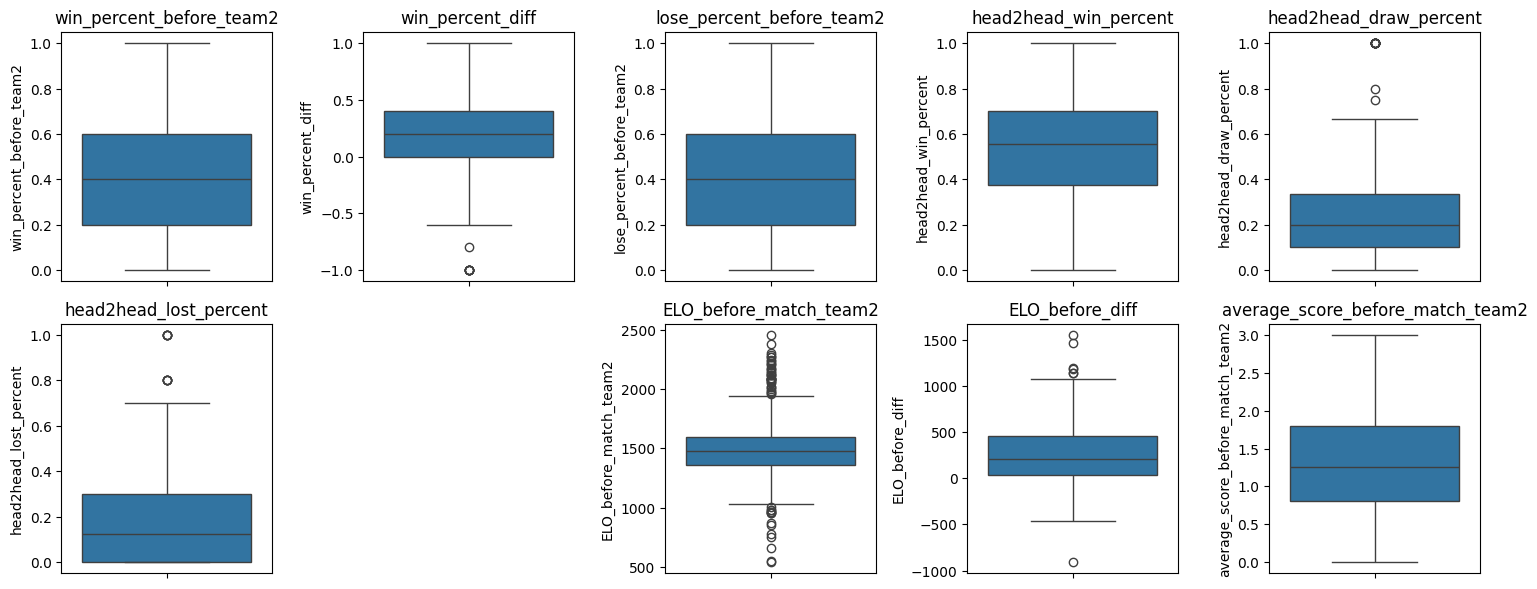

In [758]:
# Đặt kích thước biểu đồ
plt.figure(figsize=(15, 6))

# Lặp qua từng cột và vẽ histogram
for i, col in enumerate(numerical_cols):

    if col == "is_opponent_big6":
        continue
    plt.subplot(2, 5, i+1)
    sns.boxplot(X[col]) # Vẽ histogram và đường cong phân phối
    plt.title(col)

plt.tight_layout()
plt.show()

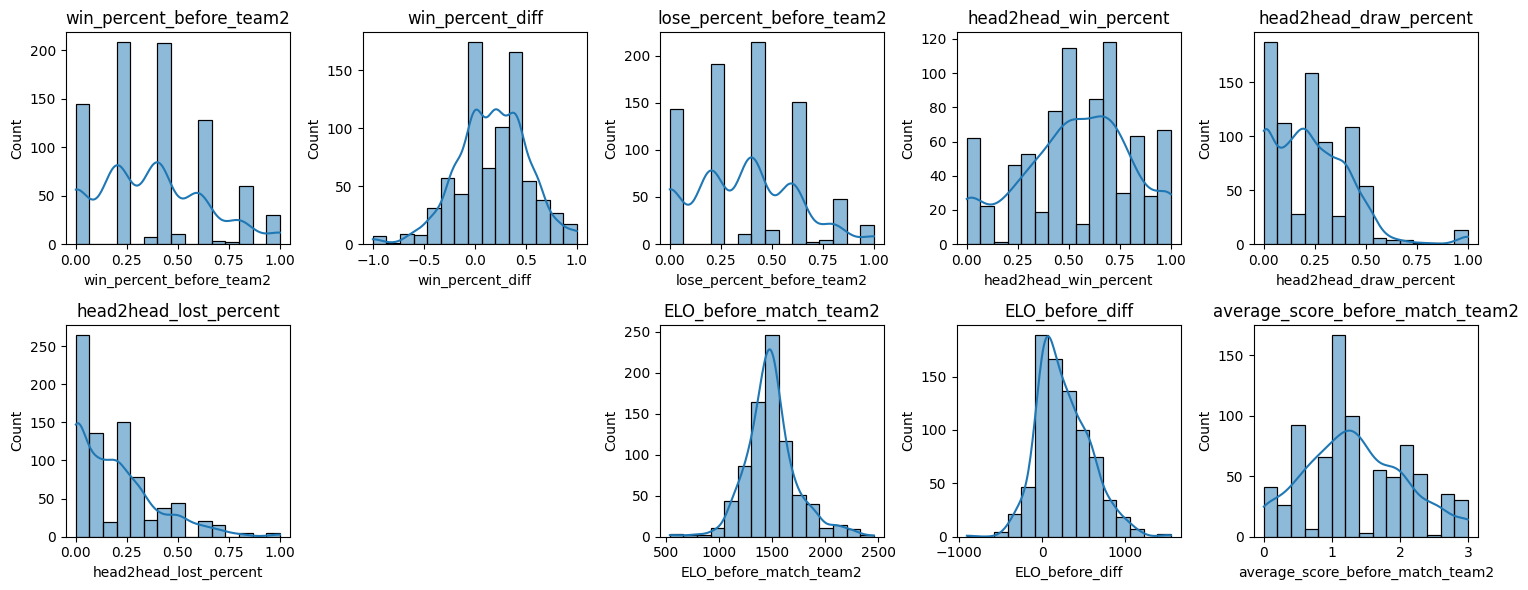

In [759]:
# Đặt kích thước biểu đồ
plt.figure(figsize=(15, 6))

# Lặp qua từng cột và vẽ histogram
for i, col in enumerate(numerical_cols):
    if col == "is_opponent_big6":
        continue
    plt.subplot(2, 5, i+1)
    sns.histplot(X[col], bins=15, kde=True) # Vẽ histogram và đường cong phân phối
    plt.title(col)

plt.tight_layout()
plt.show()

- win_percent_before_team2:
    + Phân phối không chuẩn và nằm trong khoảng [0, 1].
    + MinMaxScaler phù hợp vì giữ được phạm vi của dữ liệu.

- win_percent_diff:
    + Phân phối không chuẩn và nằm trong khoảng [-1, 1].
    + RobustScaler phù hợp

- lose_percent_before_team2:
    + Phân phối không chuẩn và nằm trong khoảng [0, 1].
    + MinMaxScaler phù hợp vì giữ được phạm vi của dữ liệu.

- head2head_win_percent:
    + Phân phối gần như chuẩn nhưng cũng nằm trong khoảng [0, 1].
    + MinMaxScaler phù hợp để giữ phạm vi dữ liệu, mặc dù StandardScaler cũng có thể xem xét nếu muốn nhấn mạnh vào việc bảo tồn hình dạng phân phối.

- head2head_draw_percent:
    + Phân phối không chuẩn và nằm trong khoảng [0, 1].
    + MinMaxScaler phù hợp vì giữ được phạm vi của dữ liệu.

- head2head_lost_percent:
    + Phân phối không chuẩn và nằm trong khoảng [0, 1].
    + MinMaxScaler phù hợp vì giữ được phạm vi của dữ liệu.

- ELO_before_match_team2:
    + Phân phối khá chuẩn nhưng có một số outliers.
    + RobustScaler phù hợp

- ELO_before_diff:
    + Phân phối khá chuẩn nhưng có một số outliers.
    + RobustScaler phù hợp

- average_score_before_match_team2:
    + Phân phối khá chuẩn và không có outliers.
    + StandardScaler phù hợp để chuẩn hóa.

##### Đặc trưng trước clustering

In [760]:
X_no_cluster = X.copy()

In [761]:
preprocessor_cat = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(use_cat_names=True), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
    ]
)

transformed_X_cat = preprocessor_cat.fit_transform(X_no_cluster)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor_cat.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor_cat.named_transformers_["season"].get_feature_names_out())
)

# Nối các cột numerical vào transformed_X_cat
encoded_cat_df = pd.DataFrame(transformed_X_cat, columns=columns)
transformed_X = pd.concat([encoded_cat_df, X[numerical_cols]], axis=1)

X = pd.DataFrame(transformed_X, columns=columns + list(numerical_cols))
X.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,1,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,1500.000000,0.000000,0.000000
1,0,1,0,0,0,0,1,1.000000,-1.000000,0.000000,0.0,0.0,0.0,1,1531.250000,-62.500000,3.000000
2,0,1,0,0,0,0,1,0.500000,0.000000,0.500000,0.0,0.0,0.0,0,1513.545664,-0.621645,1.500000
3,1,0,0,0,0,0,1,0.333333,0.333333,0.333333,0.0,0.0,0.0,1,1507.852086,42.639029,1.333333
4,1,0,0,0,0,0,1,0.250000,0.250000,0.500000,0.0,0.0,0.0,0,1456.587085,96.956843,1.000000


##### Dùng phương pháp SMOTE để cân bằng dữ liệu vì dữ liệu bị lệch nhiều

In [762]:
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5], random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X, y)

##### Chuẩn hoá cho các cột numerical

Xem xét có thể loại bỏ luôn ngoại lệ?

In [763]:
# print(X[X["head2head_win_percent"] == 0].shape[0]) # 62
# print(X[X["head2head_draw_percent"] == 1].shape[0])

# IQR = X["head2head_lost_percent"].quantile(0.75) - X["head2head_lost_percent"].quantile(0.25)
# upper_bound = X["head2head_lost_percent"].quantile(0.75) + 1.5 * IQR
# print(X[X["head2head_lost_percent"] > upper_bound].shape[0]) # 16

In [764]:
# Định nghĩa các cột số và scaler tương ứng
std_numerical_cols = [
    "average_score_before_match_team2",
]

min_max_numerical_cols = [
    "win_percent_before_team2",
    "lose_percent_before_team2",
    "head2head_win_percent",
    "head2head_draw_percent",
    "head2head_lost_percent",
]

robust_numerical_cols = [
    "win_percent_diff",
    "ELO_before_match_team2",
    "ELO_before_diff",
]

In [765]:
X_num = X_resampled[numerical_cols]
X_num.head()

,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,1500.000000,0.000000,0.000000
1,1.000000,-1.000000,0.000000,0.0,0.0,0.0,1,1531.250000,-62.500000,3.000000
2,0.500000,0.000000,0.500000,0.0,0.0,0.0,0,1513.545664,-0.621645,1.500000
3,0.333333,0.333333,0.333333,0.0,0.0,0.0,1,1507.852086,42.639029,1.333333
4,0.250000,0.250000,0.500000,0.0,0.0,0.0,0,1456.587085,96.956843,1.000000


In [766]:
# Tạo một ColumnTransformer để áp dụng các scaler
preprocessor_num = ColumnTransformer(
    transformers=[
        ('num_std', StandardScaler(), std_numerical_cols),
        ('num_minmax', MinMaxScaler(), min_max_numerical_cols),
        ('num_robust', RobustScaler(), robust_numerical_cols),
    ],
    remainder='passthrough'  # giữ nguyên các cột không được chỉ định
)

# Áp dụng transformer cho toàn bộ DataFrame
X_transformed = preprocessor_num.fit_transform(X_num)

# Định nghĩa tên các cột sau khi biến đổi
transformed_columns = std_numerical_cols + min_max_numerical_cols + robust_numerical_cols + [col for col in X.columns if col not in (std_numerical_cols + min_max_numerical_cols  + robust_numerical_cols)]

# Tạo DataFrame cho dữ liệu đã được chuẩn hóa
transformed_df = pd.DataFrame(X_num, columns=transformed_columns, index=X_num.index)

# Sắp xếp lại các cột theo thứ tự mong muốn
final_columns = [
    'win_percent_before_team2', 'win_percent_diff', 'lose_percent_before_team2', 'head2head_win_percent',
    'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6', 'ELO_before_match_team2', 
    'ELO_before_diff', 'average_score_before_match_team2'
]

final_df = transformed_df[final_columns]

X_resampled = pd.concat([X_resampled[['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2', 'season_3', 'season_4']], final_df], axis=1)


# Hiển thị 5 dòng đầu tiên của DataFrame cuối cùng
X_resampled.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,1,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,1500.000000,0.000000,0.000000
1,0,1,0,0,0,0,1,1.000000,-1.000000,0.000000,0.0,0.0,0.0,1,1531.250000,-62.500000,3.000000
2,0,1,0,0,0,0,1,0.500000,0.000000,0.500000,0.0,0.0,0.0,0,1513.545664,-0.621645,1.500000
3,1,0,0,0,0,0,1,0.333333,0.333333,0.333333,0.0,0.0,0.0,1,1507.852086,42.639029,1.333333
4,1,0,0,0,0,0,1,0.250000,0.250000,0.500000,0.0,0.0,0.0,0,1456.587085,96.956843,1.000000


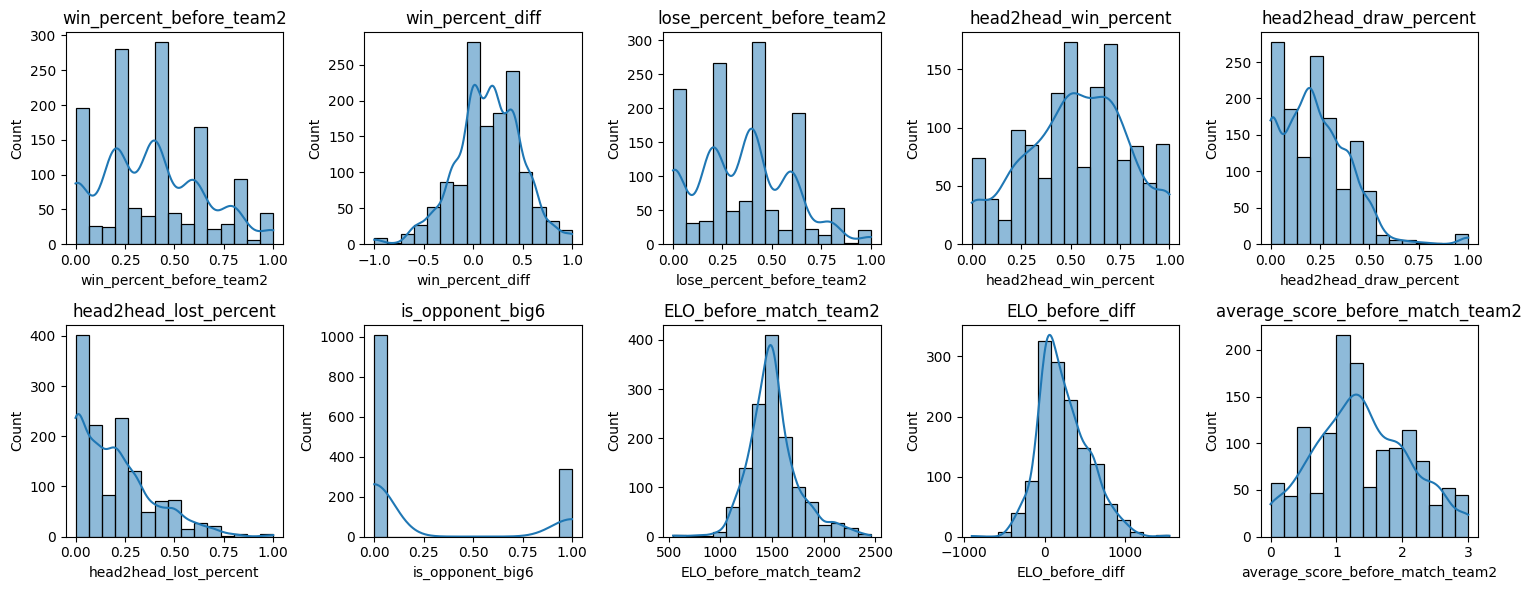

In [767]:
# Đặt kích thước biểu đồ
plt.figure(figsize=(15, 6))

# Lặp qua từng cột và vẽ histogram
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 5, i+1)
    sns.histplot(X_resampled[col], bins=15, kde=True) # Vẽ histogram và đường cong phân phối
    plt.title(col)

plt.tight_layout()
plt.show()

In [768]:
X_resampled.shape, y_resampled.shape

((1344, 17), (1344,))

In [769]:
X_resampled.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2'],
      dtype='object')

##### Đặc trưng sau clustering

In [770]:
# Định nghĩa các hàm gán nhãn
def assign_cluster_label(cluster):
    if cluster == 0:
        return 'Strong Opponent'
    elif cluster == 1:
        return 'Average Opponent'
    elif cluster == 2:
        return 'Weak Opponent'
    else:
        return 'Unknown'

def assign_win_label(cluster):
    if cluster == 0:
        return 'High Win Rate'
    elif cluster == 1:
        return 'Low Win Rate'
    elif cluster == 2:
        return 'Average Win Rate'
    else:
        return 'Unknown'

In [771]:
# Áp dụng mô hình phân cụm để dự đoán nhãn cụm cho dữ liệu kiểm thử
clusters = kmeans_model.predict(X_resampled)
X_resampled['Cluster'] = clusters
X_resampled['match_type'] = X_resampled['Cluster'].apply(assign_cluster_label)
# X_resampled['win_rate_type'] = X_resampled['Cluster'].apply(assign_win_label)

In [772]:
X_cluster = X_resampled[['Cluster', 'match_type']]

In [773]:
match_type_order = ['Weak Opponent', 'Average Opponent', 'Strong Opponent']
# win_rate_type_order = ['Low Win Rate', 'Average Win Rate', 'High Win Rate']

preprocessor_for_clustering = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["Cluster"]),
        ("match_type", OrdinalEncoder(categories=[match_type_order]), ["match_type"]),
        # ("win_rate_type", OrdinalEncoder(categories=[win_rate_type_order]), ["win_rate_type"]),
    ]
)

# Sử dụng dữ liệu X_cluster, biến này cần được định nghĩa trước
transformed_X_for_clustering = preprocessor_for_clustering.fit_transform(X_cluster)

In [774]:
# Hiển thị dữ liệu sau khi tiền xử lý
columns_for_clustering = (
    ["Cluster"]
    + list(preprocessor_for_clustering.named_transformers_["match_type"].get_feature_names_out())
    # + list(preprocessor_for_clustering.named_transformers_["win_rate_type"].get_feature_names_out())
)


transformed_X_clustering_df = pd.DataFrame(transformed_X_for_clustering, columns=columns_for_clustering)
transformed_X_clustering_df.head()

,Cluster,match_type
0,-0.054636,2.0
1,-0.054636,2.0
2,-0.054636,2.0
3,-0.054636,2.0
4,-0.054636,2.0


In [775]:
X_resampled = X_resampled.drop(columns=["Cluster", "match_type"])
transformed_X = pd.concat([X_resampled, transformed_X_clustering_df], axis=1)
transformed_X

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
0,1,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1500.000000,0.000000,0.000000,-0.054636,2.0
1,0,1,0,0,0,0,1,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1,1531.250000,-62.500000,3.000000,-0.054636,2.0
2,0,1,0,0,0,0,1,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0,1513.545664,-0.621645,1.500000,-0.054636,2.0
3,1,0,0,0,0,0,1,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,1,1507.852086,42.639029,1.333333,-0.054636,2.0
4,1,0,0,0,0,0,1,0.250000,0.250000,0.500000,0.000000,0.000000,0.000000,0,1456.587085,96.956843,1.000000,-0.054636,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,0,1,1,0,0,0,0,0.000000,0.000000,0.000000,0.204457,0.452229,0.343314,1,1500.000000,0.000000,0.522285,-0.054636,2.0
1340,1,0,1,0,1,0,0,1.000000,-1.000000,0.000000,0.124867,0.383422,0.491711,1,1543.750000,-81.250000,3.000000,-0.054636,2.0
1341,1,0,0,0,1,1,0,0.000000,0.600000,0.388652,0.341489,0.352837,0.305674,0,1292.387399,250.416271,0.611348,-0.054636,2.0
1342,1,0,0,0,1,0,0,0.112733,0.487267,0.687267,0.665450,0.221817,0.112733,0,1356.471415,232.544570,0.538199,-0.054636,2.0


In [776]:
X_resampled = transformed_X

Counter({1: 448, 2: 448, 0: 448})


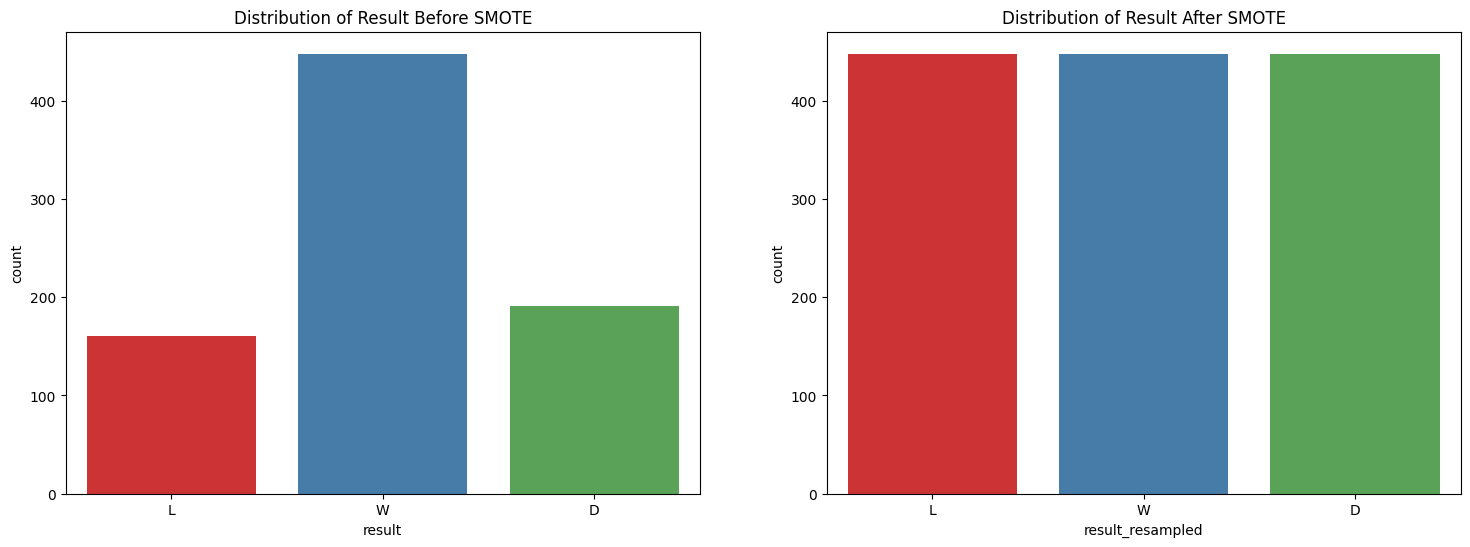

In [777]:
from collections import Counter

# Xem số lượng các giá trị trong y_resampled
counter = Counter(y_resampled)
print(counter)

# Vẽ biểu đồ phân phối của nhãn trước và sau khi áp dụng SMOTE trên cùng một figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Trước khi áp dụng SMOTE
sns.countplot(x="result", data=matches_df, palette="Set1", ax=axes[0])
axes[0].set_title('Distribution of Result Before SMOTE')

# Sau khi áp dụng SMOTE
resampled_df = pd.DataFrame(y_resampled, columns=["result_resampled"])
sns.countplot(x="result_resampled", data=resampled_df, palette="Set1", ax=axes[1])
axes[1].set_title('Distribution of Result After SMOTE')
axes[1].set_xticklabels(['L', 'W', 'D'])

plt.show()

In [778]:
X_resampled.shape

(1344, 19)

In [779]:
y_resampled.shape

(1344,)

### Thử nghiệm các mô hình

In [780]:
algorithms = [
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100, random_state=seed
        ),
    ),
    ("LR", LogisticRegression(random_state=seed)),
]

cv_results = {}

for name, model in algorithms:
    # Thực hiện cross-validation
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy")
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"Accuracy {name}: {score}")

Accuracy RF: 0.7083471531232726
Accuracy LR: 0.5119513543394141


### Chọn bộ siêu tham số

#### RF

In [781]:
# best_params_RF = {}
# models_tuned_RF = {}

# # Adjust your algorithms list to use descriptive names that match param_grid
# algorithms = [
#     ('RF', RandomForestClassifier()),
# ]

# # Define parameter grid with correct keys
# param_grid = {
#     "RF": {
#         "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
#         "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6],
#         "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
#         "min_samples_split": [2, 5, 10, 20],
#         "min_samples_leaf": [1, 2, 4, 6],
#         "class_weight": ["balanced"]
#     }
# }


# # Randomized Search application with check for parameter grid existence
# for name, model in algorithms:
#     print("Model processing: ", name)
#     if name in param_grid:
#         randomized_search = RandomizedSearchCV(
#             estimator=model, 
#             param_distributions=param_grid[name], 
#             n_iter=100,
#             cv=k_fold, 
#             scoring='accuracy', 
#             random_state=42,
#             n_jobs=-1,
#             verbose=1
#         )
#         randomized_search.fit(X_resampled, y_resampled)
#         best_params_RF[name] = randomized_search.best_params_
#         models_tuned_RF[name] = randomized_search.best_estimator_
#     else:
#         print(f"No parameter grid defined for {name}")


#### LR

In [782]:
# best_params_LR = {}
# models_tuned_LR = {}

# # Adjust your algorithms list to use descriptive names that match param_grid
# algorithms = [
#     ("LR", LogisticRegression()),
# ]

# # Define parameter grid with correct keys
# param_grid = {
#     "LR": {
#         "C": np.logspace(-4, 4, 20),  # More granular range for C
#         "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
#         "penalty": ["l1", "l2", "elasticnet", "none"],  # Different norms for regularization
#         "class_weight": ["balanced", None]  # Added class_weight
#     },
# }


# # Randomized Search application with check for parameter grid existence
# for name, model in algorithms:
#     print("Model processing: ", name)
#     if name in param_grid:
#         grid_search = GridSearchCV(
#             estimator=model, 
#             param_grid=param_grid[name],  # Use 'param_grid' instead of 'param_distributions'
#             cv=k_fold, 
#             scoring='accuracy', 
#             n_jobs=-1,
#             verbose=1,
#         )
#         grid_search.fit(X_resampled, y_resampled)
#         best_params_LR[name] = grid_search.best_params_
#         models_tuned_LR[name] = grid_search.best_estimator_
#     else:
#         print(f"No parameter grid defined for {name}")


## Thử nghiệm bộ tham số

In [783]:
cv_results_full = {}

#### Random forest

In [784]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(
        model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()
    cv_results_full[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

RF: 0.7098065229408513


#### LR

In [785]:
with open('best_params/best_params_LR.json', 'r') as f:
    best_params_LR = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params_LR.get("LR", {}), random_state=seed)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(
        model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()
    cv_results_full[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

LR: 0.5246102819237147


In [786]:
for name, score in cv_results_full.items():
    print(f"Accuracy {name}: {score}")

Accuracy RF: 0.7098065229408513
Accuracy LR: 0.5246102819237147


## Test Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất

In [787]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed, stratify=y_resampled)

In [788]:
from sklearn.metrics import confusion_matrix

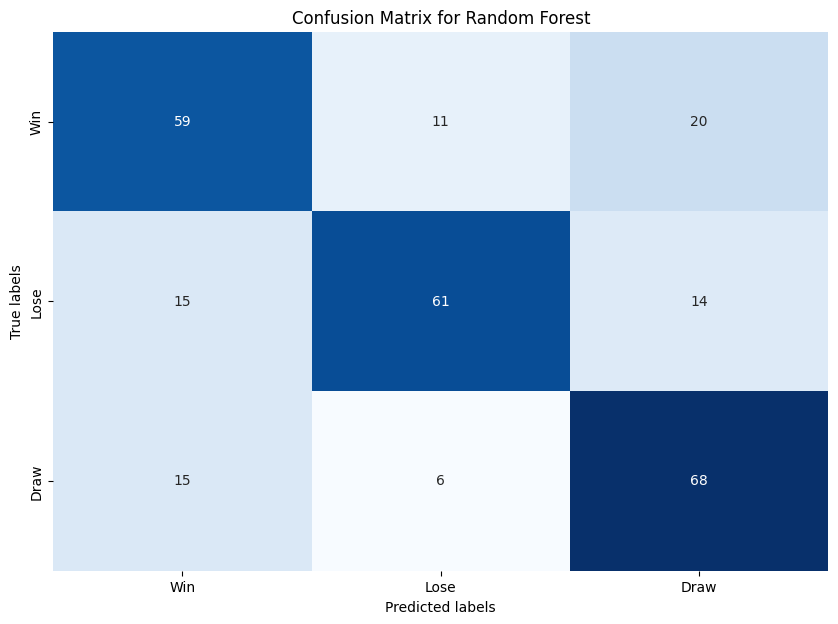

In [789]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"].pop("class_weight", None)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

cm_reordered = cm[desired_indices, :][:, desired_indices]
df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

#### LR

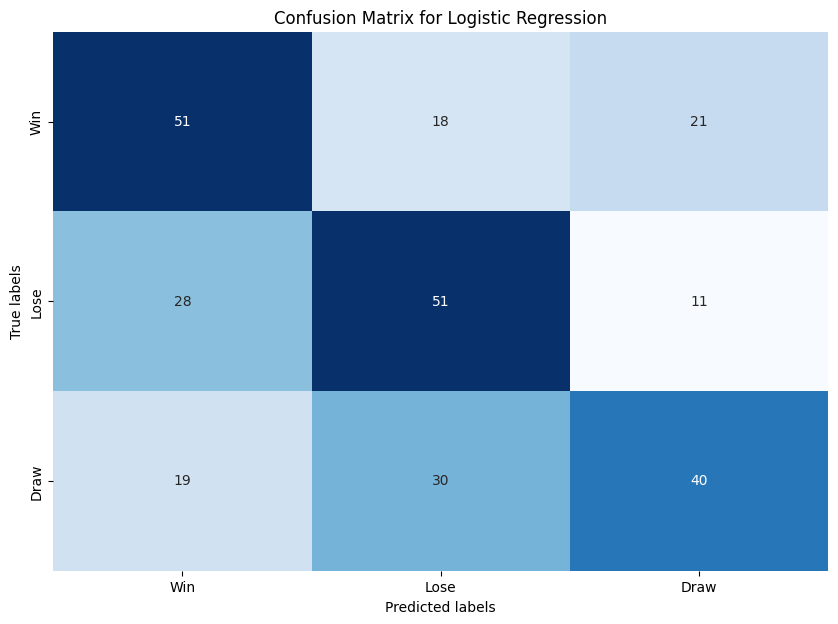

In [800]:
with open('best_params/best_params_LR.json', 'r') as f:
    best_params_LR = json.load(f)
    best_params_LR["LR"].pop("class_weight", None)

lr_model = LogisticRegression(**best_params_LR.get("LR", {}), random_state=seed)

y_pred = lr_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

cm_reordered = cm[desired_indices, :][:, desired_indices]
df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [790]:
import pickle
def save_model(model, file_name):
    with open(file_name, "wb") as file:
        pickle.dump(model, file)

In [791]:
# Lưu các encoder
save_model(preprocessor_cat, "final_model_clustered/preprocessor_cat.pkl")

In [792]:
# Lưu các encoder
save_model(preprocessor_num, "final_model_clustered/preprocessor_num.pkl")

In [793]:
# Lưu các encoder
save_model(preprocessor_for_clustering, "final_model_clustered/preprocessor_clustering.pkl")

In [794]:
X_resampled.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'Cluster', 'match_type'],
      dtype='object')

In [795]:
# Lưu model vào file joblib
import joblib

with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    # best_params_RF["RF"]["class_weight"] = "balanced"

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)
rf_model.fit(X_resampled, y_resampled)

save_model(rf_model, "final_model_clustered/RF.pkl")

In [796]:
preprocessor_cat.feature_names_in_

array(['venue', 'season', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent',
       'is_opponent_big6', 'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2'], dtype=object)

In [797]:
preprocessor_num.feature_names_in_

array(['win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent',
       'is_opponent_big6', 'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2'], dtype=object)

In [798]:
preprocessor_for_clustering.feature_names_in_

array(['Cluster', 'match_type'], dtype=object)